In [1]:
%matplotlib inline

In [2]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import tensorflow as tf

In [4]:
import pandas as pd
from scipy import signal
from scipy.io import wavfile
import seaborn as sns
import librosa
import librosa.display
from sklearn.preprocessing import StandardScaler

In [5]:
import os
import sys
import re

In [6]:
BITRATE = 16                      # Bit rate
SAMRATE = 16000                   # Sample rate (Hz)
SAMTIME = 1000.0 / SAMRATE        # Sample time (ms)
MAXAMPS = float(2**BITRATE / 2)   # Max samples amplitute

In [7]:
DATA_DIR = './data'               # Data location
OUT_DIR = './models'              # Model output location

In [8]:
LABELS_REQUIRED = ['yes', 'no', 'up', 'down', 'left',
                   'right', 'on', 'off', 'stop', 'go',
                   'silence']

In [9]:
def zero_crossing(arr):
    """Calculates the zero crossing rate"""
    if arr.ndim == 1:
        return np.count_nonzero(np.diff(np.sign(arr))) / float(arr.shape[0])
    else:
        return np.count_nonzero(np.diff(np.sign(arr)), axis=1) / float(arr.shape[1])

In [10]:
def rms_energy(arr):
    """Calculates the RMS energy of the wave"""
    if arr.ndim == 1:
        return np.sqrt(np.mean(np.square(arr / MAXAMPS)))
    else:
        return np.sqrt(np.mean(np.square(arr / MAXAMPS), axis=1))

In [11]:
def windower(arr, window=128, hop_length=32):
    """Windower function that divides an array into fixed size windows"""
    overlap = window - hop_length
    length = arr.shape[0]
    indexer = np.arange(window)[None, :] + hop_length * np.arange((length - overlap) / hop_length)[:, None]
    return arr[indexer]

In [12]:
def load_data(data_dir):
    """Loads data into training and validation sets"""
    with open(os.path.join(data_dir, 'train', 'validation_list.txt'), 'r') as fin:
        validation_files = set([f.strip() for f in fin.readlines()])

    with open(os.path.join(data_dir, 'train', 'testing_list.txt'), 'r') as fin:
        testing_files = set([f.strip() for f in fin.readlines()])
        
    pattern = re.compile(r"([^_]+)_nohash_([^\.]+)\.wav")
    audio_dir = os.path.join(data_dir, 'train', 'audio')
    labels_req = set(LABELS_REQUIRED)

    file_list = []
    
    for d in os.listdir(audio_dir):
        files = os.listdir(os.path.join(audio_dir, d))
        reqlabel_flag = d in labels_req
        if reqlabel_flag:
            reqlabel = d
        else:
            reqlabel = 'unknown'
        
        for f in files:
            ffull = os.path.join(d, f)
            if ffull in validation_files:
                setlabel = 'val'
            elif ffull in testing_files:
                setlabel = 'test'
            else:
                setlabel = 'train'
            r = re.match(pattern, f)
            if r:
                file_list.append([ffull, d, r.group(1), int(r.group(2)),
                                  setlabel, reqlabel, reqlabel_flag])
    
    return pd.DataFrame(file_list, columns=['filepath', 'label', 'uid', 'uversion',
                                            'setlabel', 'reqlabel', 'reqlabelflag'])

In [13]:
d = load_data(DATA_DIR)

In [14]:
# Data frame for all training/test/validation file information
d.head()

,filepath,label,uid,uversion,setlabel,reqlabel,reqlabelflag
0,right/988e2f9a_nohash_0.wav,right,988e2f9a,0,train,right,True
1,right/1eddce1d_nohash_3.wav,right,1eddce1d,3,train,right,True
2,right/93ec8b84_nohash_0.wav,right,93ec8b84,0,train,right,True
3,right/6272b231_nohash_1.wav,right,6272b231,1,train,right,True
4,right/439c84f4_nohash_1.wav,right,439c84f4,1,val,right,True


## Feature extraction

In [15]:
# Select a random file to explore
testfile = d.iloc[2342]

In [16]:
testfile

filepath        right/b7a0754f_nohash_1.wav
label                                 right
uid                                b7a0754f
uversion                                  1
setlabel                              train
reqlabel                              right
reqlabelflag                           True
Name: 2342, dtype: object

In [17]:
sr, wave = wavfile.read(os.path.join(DATA_DIR, 'train', 'audio', testfile.filepath))

In [18]:
sr

16000

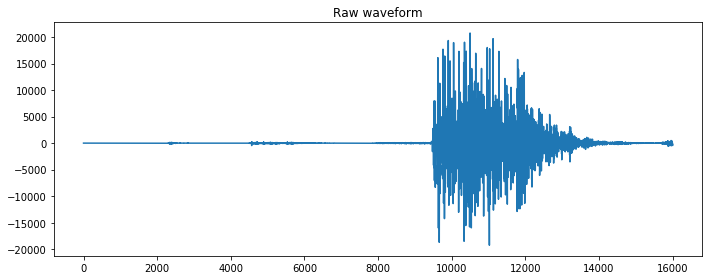

In [19]:
plt.figure(figsize=(10, 4))
plt.plot(wave)
plt.title('Raw waveform')
plt.tight_layout();

In [20]:
# Spectrogram calclated using scipy.signal
f, t, Sxx = signal.spectrogram(wave, fs=sr, window=('tukey', 0.25), nperseg=64)

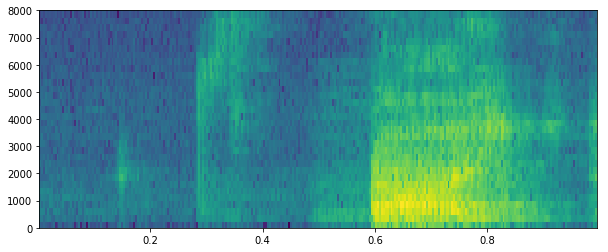

In [21]:
plt.figure(figsize=(10, 4))
plt.pcolormesh(t, f, np.log(Sxx));

In [22]:
melspec = librosa.feature.melspectrogram(wave, sr=sr, power=2, n_mels=64,
                                         n_fft=256, hop_length=128)

melspec_db = librosa.power_to_db(melspec, ref=np.max)

melspec_log = np.log(melspec)

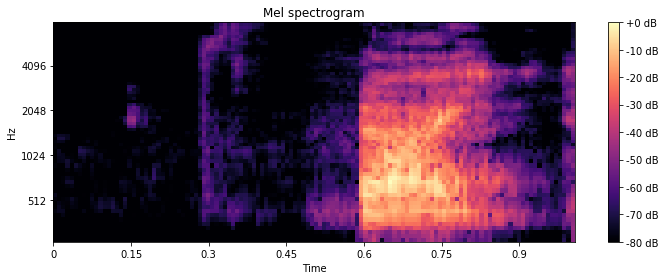

In [23]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(melspec_db, sr=sr, hop_length=128,
                         y_axis='mel', fmax=8000,
                         x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout();

In [24]:
melspec.shape

(64, 126)

In [25]:
mfcc = librosa.feature.mfcc(wave, sr=sr, n_mels=64, n_fft=512, hop_length=128, n_mfcc=19)

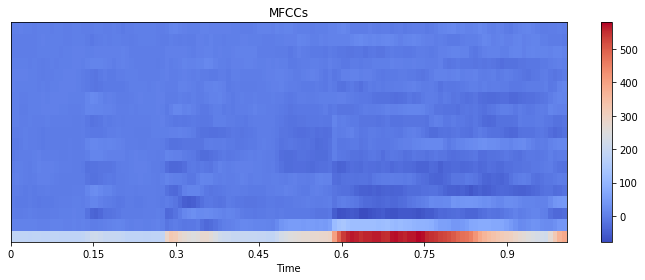

In [26]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time', sr=sr, hop_length=128)
plt.colorbar()
plt.title('MFCCs')
plt.tight_layout();

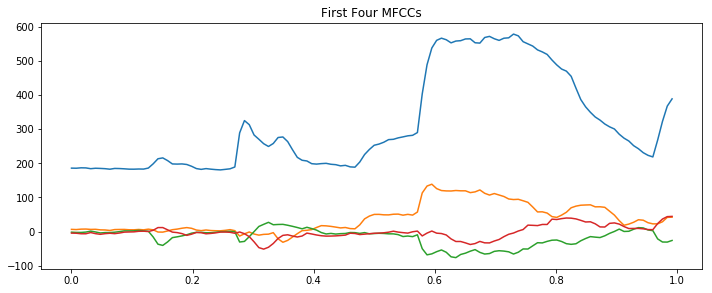

In [27]:
plt.figure(figsize=(10, 4))
t = np.arange(0, 1.0, 1. / len(mfcc[0]))
plt.plot(t, mfcc[0], t, mfcc[1], t, mfcc[2], t, mfcc[3])
plt.tight_layout()
plt.title('First Four MFCCs');

In [28]:
wave_w = windower(wave, window=512, hop_length=128)

In [29]:
zcr = zero_crossing(wave_w)
rmse = rms_energy(wave_w)

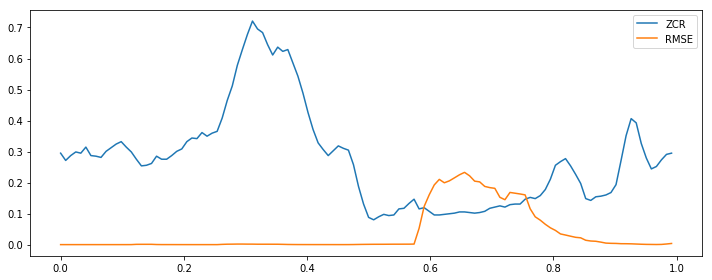

In [30]:
plt.figure(figsize=(10, 4))
t = np.arange(0, 1.0, 1. / len(zcr))
plt.plot(t, zcr, label="ZCR")
plt.plot(t, rmse, label="RMSE")
plt.legend()
plt.tight_layout();

In [31]:
# Feature shapes
print zcr.shape
print rmse.shape
print mfcc.shape
print melspec_log.shape

(122,)
(122,)
(19, 126)
(64, 126)


## Combine into single feature map (for exploration only)

In [32]:
mfcc_log = np.log(mfcc - mfcc.min() + 0.1)

In [33]:
ws = min(zcr.shape[0], mfcc.shape[1])

In [34]:
mfcc_log_resize = mfcc_log[:, :ws]
melspec_log_resize = melspec_log[:, :ws]

In [35]:
features = np.vstack((mfcc_log_resize / 10., zcr, rmse, melspec_log_resize / 20.))

In [36]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features.T).T

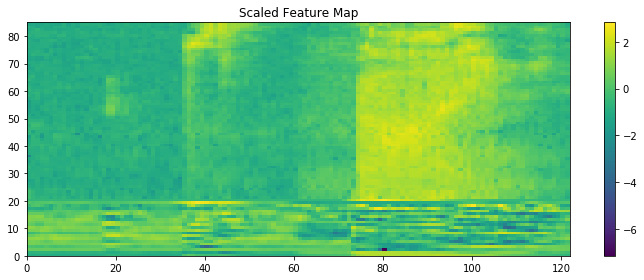

In [37]:
plt.figure(figsize=(10, 4))
plt.pcolormesh(features_scaled)
plt.colorbar()
plt.title('Scaled Feature Map')
plt.tight_layout();

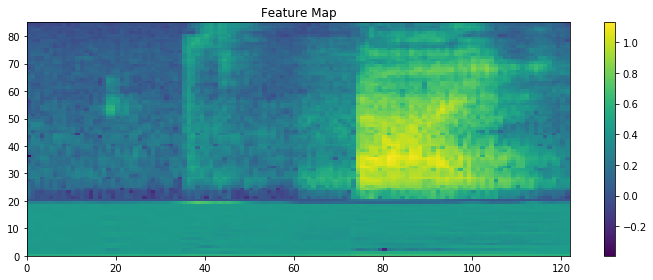

In [38]:
plt.figure(figsize=(10, 4))
plt.pcolormesh(features)
plt.colorbar()
plt.title('Feature Map')
plt.tight_layout();